# Molecular Classification of P53 Agonists via Artifical Neural Network Part 2

<br>
<center><b>Author: Jonathan Hampton</b></center>

<br>
<center><b>November 2019</b></center>

In [60]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib
import numpy as np
import deepchem as dc
import deepchem
from rdkit import Chem
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load data
from numpy import load

X_train = load('data/X_train_OG.npy')
y_train = load('data/y_train_OG.npy')

X_test = load('data/X_test.npy')
y_test = load('data/y_test.npy')

X_train_resamp1 = load('data/X_train_resamp1.npy')
y_train_resamp1 = load('data/y_train_resamp1.npy')

X_train_resamp2 = load('data/X_train_resamp2.npy')
y_train_resamp2 = load('data/y_train_resamp2.npy')

X_train_resamp3 = load('data/X_train_resamp3.npy')
y_train_resamp3 = load('data/y_train_resamp3.npy')

X_train_resamp4 = load('data/X_train_resamp4.npy')
y_train_resamp4 = load('data/y_train_resamp4.npy')

X_train_resamp5 = load('data/X_train_resamp5.npy')
y_train_resamp5 = load('data/y_train_resamp5.npy')

## Building the Pytorch Neural Network

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier

In [4]:
class ToxModelV1(nn.Module):
    
    def __init__(self, in_sz=5000, out_sz=4, nonlin=F.relu):
        super().__init__()
        self.nonlin = nonlin
        self.fc1 = nn.Linear(in_sz, 250)
        self.fc2 = nn.Linear(250, 65)
        self.fc3 = nn.Linear(65, out_sz)
        
    def forward(self, X):
        X = self.nonlin((self.fc1(X)))
        X = self.nonlin((self.fc2(X)))
        X = F.softmax((self.fc3(X)), dim=1)
        X0 = torch.sqrt(X[:,0]*(1-X[:,1]))
        X1 = (torch.sqrt(X[:,2]*(1-X[:,3])))
        X = X0, X1
        return torch.stack(X).transpose(0,1)
        
    

In [5]:
torch.manual_seed(314)
ToxModelV1()

ToxModelV1(
  (fc1): Linear(in_features=5000, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=65, bias=True)
  (fc3): Linear(in_features=65, out_features=4, bias=True)
)

In [6]:
# a less complex model with only two layers...

class ToxModelV2(nn.Module):
    
    def __init__(self, in_sz=5000, out_sz=4, nonlin=F.relu):
        super().__init__()
        self.nonlin = nonlin
        self.fc1 = nn.Linear(in_sz, 100)
        self.fc2 = nn.Linear(100, out_sz)
        
    def forward(self, X):
        X = self.nonlin((self.fc1(X)))
        X = F.softmax((self.fc2(X)), dim=1)
        X0 = torch.sqrt(X[:,0]*(1-X[:,1]))
        X1 = (torch.sqrt(X[:,2]*(1-X[:,3])))
        X = X0, X1
        return torch.stack(X).transpose(0,1)

In [7]:
torch.manual_seed(314)
ToxModelV2()

ToxModelV2(
  (fc1): Linear(in_features=5000, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [8]:
model = NeuralNetClassifier(ToxModelV1, train_split=None, iterator_train__shuffle=False,
                            optimizer=torch.optim.Adam, criterion = nn.CrossEntropyLoss)

## Grid Search Cross Validation

First with the original data

In [9]:
# Sklearn Grid Search

from sklearn.model_selection import GridSearchCV


params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs.fit(X_train,y_train)

print(gs.best_score_, gs.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.4908  0.4028
      2        0.3770  0.3930
      3        0.3759  0.3932
      4           nan  0.3956
      5           nan  0.3867
0.9379959402103709 {'lr': 0.001, 'max_epochs': 5, 'module__nonlin': <function relu at 0x17a1130d0>}


Now with the resampled data. First up is original data with SMOTE to oversample to minority class.

In [10]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs1 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs1.fit(X_train_resamp1,y_train_resamp1)

print(gs1.best_score_, gs1.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6965  0.7371
      2        0.6880  0.7208
      3        0.6702  0.7391
      4        0.6263  0.7217
      5        0.5490  0.7227
      6        0.4798  0.7207
      7        0.4301  0.7211
      8        0.3973  0.7201
      9        0.3763  0.7325
     10        0.3622  0.7421
0.946586661420421 {'lr': 0.0001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


Now for the data with undersampling (n_neighbors = 30) applied to the majority class first, then SMOTE to balance the minority class.

In [11]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs2 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs2.fit(X_train_resamp2,y_train_resamp2)

print(gs2.best_score_, gs2.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7004  0.1132
      2        0.6788  0.1001
      3        0.6513  0.0982
      4        0.5803  0.0974
      5        0.4667  0.0956
      6        0.3744  0.0950
      7        0.3387  0.0952
      8        0.3253  0.0944
      9        0.3198  0.0985
     10        0.3175  0.0984
0.9692653673163418 {'lr': 0.001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


Next for the data with undersampling of n_neighbors = 20

In [12]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs3 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs3.fit(X_train_resamp3,y_train_resamp3)

print(gs3.best_score_, gs3.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7203  0.2663
      2        0.6508  0.2447
      3        0.5935  0.2031
      4        0.5096  0.1918
      5        0.4353  0.1833
      6        0.3502  0.1709
      7        0.3244  0.1670
      8        0.3186  0.1751
      9        0.3170  0.1775
     10        0.3161  0.1636
0.9856770833333334 {'lr': 0.001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


Next for the data with undersampling of n_neighbors = 15

In [13]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs4 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs4.fit(X_train_resamp4,y_train_resamp4)

print(gs4.best_score_, gs4.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7523  0.3396
      2        0.6429  0.3456
      3        0.5586  0.3470
      4        0.4421  0.3459
      5        0.3405  0.3401
      6        0.3230  0.2954
      7        0.3201  0.3668
      8        0.3187  0.3654
      9        0.3180  0.3756
     10        0.3164  0.4188
0.9848484848484849 {'lr': 0.001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


Lastly, the data with undersampling of n_neighbors = 10

In [14]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs5 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs5.fit(X_train_resamp5,y_train_resamp5)

print(gs5.best_score_, gs5.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.8293  0.4523
      2        0.6242  0.4604
      3        0.5402  0.4651
      4        0.3840  0.4750
      5        0.3373  0.4401
      6        0.3212  0.4578
      7        0.3182  0.4573
      8        0.3168  0.4560
      9        0.3150  0.4465
     10        0.3142  0.4541
0.9871021775544389 {'lr': 0.001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


# Testing

In [15]:
test_preds_OG = gs.predict(X_test)

test_preds_1 = gs1.predict(X_test)

test_preds_2 = gs2.predict(X_test)

test_preds_3 = gs3.predict(X_test)

test_preds_4 = gs4.predict(X_test)

test_preds_5 = gs5.predict(X_test)

In [16]:
test_pred_probs_OG = gs.predict_proba(X_test)

test_pred_probs_1 = gs1.predict_proba(X_test)

test_pred_probs_2 = gs2.predict_proba(X_test)

test_pred_probs_3 = gs3.predict_proba(X_test)

test_pred_probs_4 = gs4.predict_proba(X_test)

test_pred_probs_5 = gs5.predict_proba(X_test)

## Evaluation

Classification report with the original data:

In [17]:
from sklearn.metrics import classification_report


report_m1_OG = classification_report(y_test, test_preds_OG, output_dict=True)
print(report_m1_OG)

{'0': {'precision': 0.9357933579335793, 'recall': 1.0, 'f1-score': 0.9668318719024018, 'support': 1268}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 87}, 'accuracy': 0.9357933579335793, 'macro avg': {'precision': 0.46789667896678966, 'recall': 0.5, 'f1-score': 0.4834159359512009, 'support': 1355}, 'weighted avg': {'precision': 0.875709208752604, 'recall': 0.9357933579335793, 'f1-score': 0.9047548439647568, 'support': 1355}}


/Users/jonathanhampton/.conda/envs/deepchem/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification report with JUST SMOTE. <b> (No Undersampling) <b/>

In [18]:
report_m1_1 = classification_report(y_test, test_preds_1, output_dict=True)
print(report_m1_1)

{'0': {'precision': 0.9629934210526315, 'recall': 0.9235015772870663, 'f1-score': 0.9428341384863124, 'support': 1268}, '1': {'precision': 0.302158273381295, 'recall': 0.4827586206896552, 'f1-score': 0.37168141592920356, 'support': 87}, 'accuracy': 0.8952029520295203, 'macro avg': {'precision': 0.6325758472169632, 'recall': 0.7031300989883608, 'f1-score': 0.6572577772077579, 'support': 1355}, 'weighted avg': {'precision': 0.9205634152611879, 'recall': 0.8952029520295203, 'f1-score': 0.9061623400638265, 'support': 1355}}


Now for the resampled date in which the majority class was undersampled first, then SMOTE was applied to the minority class.

Undersampling with n_neighbors = 25 :

In [19]:
report_m1_2 = classification_report(y_test, test_preds_2, output_dict=True)
print(report_m1_2)

{'0': {'precision': 0.9897540983606558, 'recall': 0.38091482649842273, 'f1-score': 0.5501138952164009, 'support': 1268}, '1': {'precision': 0.09457900807381776, 'recall': 0.9425287356321839, 'f1-score': 0.1719077568134172, 'support': 87}, 'accuracy': 0.41697416974169743, 'macro avg': {'precision': 0.5421665532172367, 'recall': 0.6617217810653033, 'f1-score': 0.361010826014909, 'support': 1355}, 'weighted avg': {'precision': 0.932277911751833, 'recall': 0.41697416974169743, 'f1-score': 0.5258305490606374, 'support': 1355}}


Undersampling with n_neighbors = 20 :

In [20]:
report_m1_3 = classification_report(y_test, test_preds_3, output_dict=True)
print(report_m1_3)

{'0': {'precision': 0.9817158931082982, 'recall': 0.5504731861198738, 'f1-score': 0.7054067710965134, 'support': 1268}, '1': {'precision': 0.11490683229813664, 'recall': 0.8505747126436781, 'f1-score': 0.2024623803009576, 'support': 87}, 'accuracy': 0.5697416974169742, 'macro avg': {'precision': 0.5483113627032175, 'recall': 0.700523949381776, 'f1-score': 0.4539345756987355, 'support': 1355}, 'weighted avg': {'precision': 0.9260609940009298, 'recall': 0.5697416974169742, 'f1-score': 0.6731144006173891, 'support': 1355}}


Undersampling with n_neighbors = 15 :

In [21]:
report_m1_4 = classification_report(y_test, test_preds_4, output_dict=True)
print(report_m1_4)

{'0': {'precision': 0.9716981132075472, 'recall': 0.7310725552050473, 'f1-score': 0.8343834383438343, 'support': 1268}, '1': {'precision': 0.14962593516209477, 'recall': 0.6896551724137931, 'f1-score': 0.24590163934426232, 'support': 87}, 'accuracy': 0.7284132841328413, 'macro avg': {'precision': 0.560662024184821, 'recall': 0.7103638638094203, 'f1-score': 0.5401425388440483, 'support': 1355}, 'weighted avg': {'precision': 0.91891561911902, 'recall': 0.7284132841328413, 'f1-score': 0.7965989981128654, 'support': 1355}}


Undersampling with n_neighbors = 10 :

In [22]:
report_m1_5 = classification_report(y_test, test_preds_5, output_dict=True)
print(report_m1_5)

{'0': {'precision': 0.9594827586206897, 'recall': 0.8777602523659306, 'f1-score': 0.9168039538714992, 'support': 1268}, '1': {'precision': 0.20512820512820512, 'recall': 0.45977011494252873, 'f1-score': 0.2836879432624113, 'support': 87}, 'accuracy': 0.8509225092250923, 'macro avg': {'precision': 0.5823054818744474, 'recall': 0.6687651836542297, 'f1-score': 0.6002459485669552, 'support': 1355}, 'weighted avg': {'precision': 0.9110481858134231, 'recall': 0.8509225092250923, 'f1-score': 0.8761537007918012, 'support': 1355}}


## ROC Curve

In [23]:
from sklearn import metrics

In [24]:
from sklearn.metrics import auc, roc_curve

from sklearn.utils import check_matplotlib_support


class RocCurveDisplay:
    """ROC Curve visualization.
    It is recommend to use :func:`~sklearn.metrics.plot_roc_curve` to create a
    visualizer. All parameters are stored as attributes.
    Read more in the :ref:`User Guide <visualizations>`.
    Parameters
    ----------
    fpr : ndarray
        False positive rate.
    tpr : ndarray
        True positive rate.
    roc_auc : float
        Area under ROC curve.
    estimator_name : str
        Name of estimator.
    Attributes
    ----------
    line_ : matplotlib Artist
        ROC Curve.
    ax_ : matplotlib Axes
        Axes with ROC Curve.
    figure_ : matplotlib Figure
        Figure containing the curve.
    """

    def __init__(self, fpr, tpr, roc_auc, estimator_name):
        self.fpr = fpr
        self.tpr = tpr
        self.roc_auc = roc_auc
        self.estimator_name = estimator_name

    def plot(self, ax=None, name=None, **kwargs):
        """Plot visualization
        Extra keyword arguments will be passed to matplotlib's ``plot``.
        Parameters
        ----------
        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.
        name : str, default=None
            Name of ROC Curve for labeling. If `None`, use the name of the
            estimator.
        Returns
        -------
        display : :class:`~sklearn.metrics.plot.RocCurveDisplay`
            Object that stores computed values.
        """
        check_matplotlib_support('RocCurveDisplay.plot')
        import matplotlib.pyplot as plt

        if ax is None:
            fig, ax = plt.subplots()

        name = self.estimator_name if name is None else name

        line_kwargs = {
            'label': "{} (AUC = {:0.2f})".format(name, self.roc_auc)
        }
        line_kwargs.update(**kwargs)

        self.line_ = ax.plot(self.fpr, self.tpr, **line_kwargs)[0]
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc='lower right')

        self.ax_ = ax
        self.figure_ = ax.figure
        return self


def plot_roc_curve(estimator, X, y, pos_label=None, sample_weight=None,
                   drop_intermediate=True, response_method="auto",
                   name=None, ax=None, **kwargs):
    """Plot Receiver operating characteristic (ROC) curve.
    Extra keyword arguments will be passed to matplotlib's `plot`.
    Read more in the :ref:`User Guide <visualizations>`.
    Parameters
    ----------
    estimator : estimator instance
        Trained classifier.
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Input values.
    y : array-like of shape (n_samples,)
        Target values.
    pos_label : int or str, default=None
        The label of the positive class.
        When `pos_label=None`, if y_true is in {-1, 1} or {0, 1},
        `pos_label` is set to 1, otherwise an error will be raised.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    drop_intermediate : boolean, default=True
        Whether to drop some suboptimal thresholds which would not appear
        on a plotted ROC curve. This is useful in order to create lighter
        ROC curves.
    response_method : {'predict_proba', 'decision_function', 'auto'} \
    default='auto'
        Specifies whether to use :term:`predict_proba` or
        :term:`decision_function` as the target response. If set to 'auto',
        :term:`predict_proba` is tried first and if it does not exist
        :term:`decision_function` is tried next.
    name : str, default=None
        Name of ROC Curve for labeling. If `None`, use the name of the
        estimator.
    ax : matplotlib axes, default=None
        Axes object to plot on. If `None`, a new figure and axes is created.
    Returns
    -------
    display : :class:`~sklearn.metrics.RocCurveDisplay`
        Object that stores computed values.
    """
    check_matplotlib_support('plot_roc_curve')

    if response_method not in ("predict_proba", "decision_function", "auto"):
        raise ValueError("response_method must be 'predict_proba', "
                         "'decision_function' or 'auto'")

    if response_method != "auto":
        prediction_method = getattr(estimator, response_method, None)
        if prediction_method is None:
            raise ValueError(
                "response method {} is not defined".format(response_method))
    else:
        predict_proba = getattr(estimator, 'predict_proba', None)
        decision_function = getattr(estimator, 'decision_function', None)
        prediction_method = predict_proba or decision_function

        if prediction_method is None:
            raise ValueError('response methods not defined')

    y_pred = prediction_method(X)

    if y_pred.ndim != 1:
        if y_pred.shape[1] > 2:
            raise ValueError("Estimator should solve a "
                             "binary classification problem")
        y_pred = y_pred[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred, pos_label=pos_label,
                            sample_weight=sample_weight,
                            drop_intermediate=drop_intermediate)
    roc_auc = auc(fpr, tpr)
    viz = RocCurveDisplay(fpr, tpr, roc_auc, estimator.__class__.__name__)
    return viz.plot(ax=ax, name=name, **kwargs)

In [25]:
plt.style.use('ggplot')

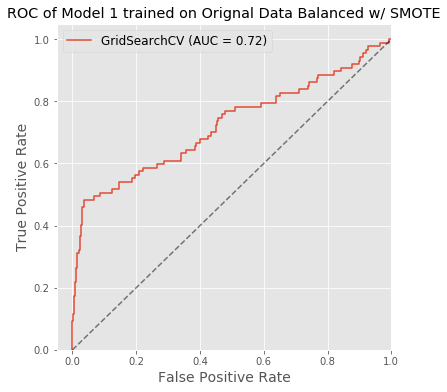

In [26]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs1, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 1 trained on Orignal Data Balanced w/ SMOTE")
ax.legend(fontsize = 12);

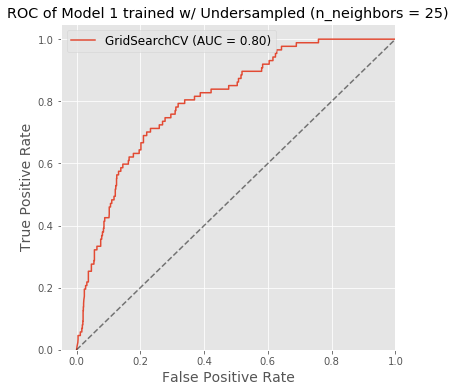

In [27]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs2, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 1 trained w/ Undersampled (n_neighbors = 25)")
ax.legend(fontsize = 12);

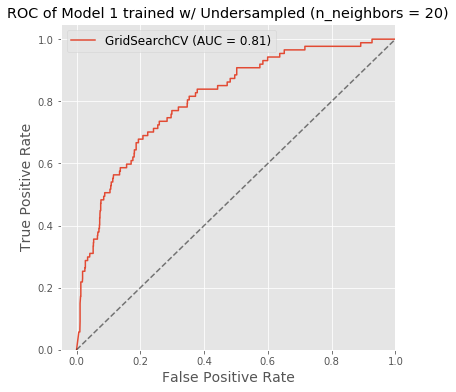

In [28]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs3, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 1 trained w/ Undersampled (n_neighbors = 20)")
ax.legend(fontsize = 12);

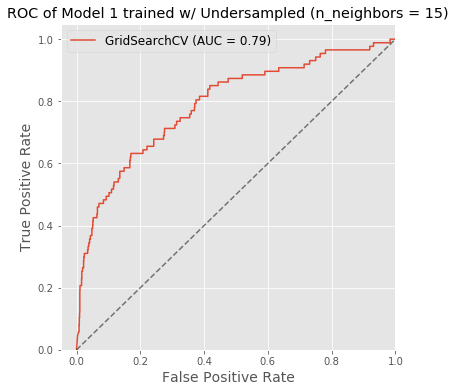

In [29]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs4, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 1 trained w/ Undersampled (n_neighbors = 15)")
ax.legend(fontsize = 12);

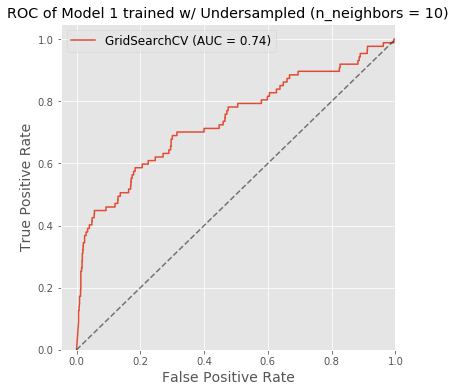

In [30]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs5, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 1 trained w/ Undersampled (n_neighbors = 10)")
ax.legend(fontsize = 12);

# A Less Complex Model

Now the Tox Model V2 is trained and tested to see if a less complex model will produce better results

In [31]:
model = NeuralNetClassifier(ToxModelV2, train_split=None, iterator_train__shuffle=False,
                            optimizer=torch.optim.Adam, criterion = nn.CrossEntropyLoss)

## Grid Search Cross Validation

First with the original data

In [32]:
# Sklearn Grid Search

from sklearn.model_selection import GridSearchCV


params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs.fit(X_train,y_train)

print(gs.best_score_, gs.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.5371  0.2254
      2        0.3922  0.2314
      3        0.3810  0.2305
      4        0.3784  0.2265
      5        0.3772  0.2229
0.9379959402103709 {'lr': 0.001, 'max_epochs': 5, 'module__nonlin': <function relu at 0x17a1130d0>}


Now with the resampled data. First up is original data with SMOTE to oversample to minority class.

In [33]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs1 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs1.fit(X_train_resamp1,y_train_resamp1)

print(gs1.best_score_, gs1.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7410  0.4318
      2        0.5426  0.4260
      3        0.5594  0.4225
      4        0.4174  0.4121
      5        0.3732  0.4166
      6        0.3518  0.4239
      7        0.3408  0.4212
      8        0.3343  0.4212
      9        0.3296  0.4610
     10        0.3267  0.5108
0.9672437536887665 {'lr': 0.001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


Now for the data with undersampling (n_neighbors = 30) applied to the majority class first, then SMOTE to balance the minority class.

In [34]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs2 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs2.fit(X_train_resamp2,y_train_resamp2)

print(gs2.best_score_, gs2.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7034  0.0907
      2        0.6620  0.0692
      3        0.6249  0.0688
      4        0.5595  0.0671
      5        0.4851  0.0624
      6        0.4241  0.0579
      7        0.3848  0.0569
      8        0.3626  0.0592
      9        0.3492  0.0583
     10        0.3406  0.0594
0.9662668665667167 {'lr': 0.001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


Next for the data with undersampling of n_neighbors = 20

In [35]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs3 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs3.fit(X_train_resamp3,y_train_resamp3)

print(gs3.best_score_, gs3.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7155  0.0972
      2        0.6477  0.0884
      3        0.6017  0.0908
      4        0.5199  0.0931
      5        0.4350  0.0885
      6        0.3832  0.0875
      7        0.3568  0.0910
      8        0.3425  0.0929
      9        0.3342  0.0916
     10        0.3292  0.0916
0.9809027777777778 {'lr': 0.001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


Next for the data with undersampling of n_neighbors = 15

In [36]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs4 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs4.fit(X_train_resamp4,y_train_resamp4)

print(gs4.best_score_, gs4.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7267  0.1592
      2        0.6387  0.1533
      3        0.5810  0.1627
      4        0.4783  0.1596
      5        0.3990  0.1550
      6        0.3586  0.1574
      7        0.3416  0.1593
      8        0.3330  0.1556
      9        0.3279  0.1574
     10        0.3243  0.1607
0.9843348741653827 {'lr': 0.001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


Lastly, the data with undersampling of n_neighbors = 10

In [37]:
params = { 'lr': [0.001,0.0001],
         'max_epochs':[5,10],
         'module__nonlin':[F.relu, torch.sigmoid],
         }

gs5 = GridSearchCV(model, params, cv=4, refit=True, scoring='accuracy', n_jobs=3)

gs5.fit(X_train_resamp5,y_train_resamp5)

print(gs5.best_score_, gs5.best_params_)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.7612  0.2395
      2        0.6102  0.2343
      3        0.5309  0.2350
      4        0.4399  0.2320
      5        0.3749  0.2321
      6        0.3477  0.2383
      7        0.3353  0.2326
      8        0.3287  0.2309
      9        0.3250  0.2330
     10        0.3223  0.2359
0.9830820770519263 {'lr': 0.001, 'max_epochs': 10, 'module__nonlin': <function relu at 0x17a1130d0>}


# Testing

In [38]:
test_preds_OG = gs.predict(X_test)

test_preds_1 = gs1.predict(X_test)

test_preds_2 = gs2.predict(X_test)

test_preds_3 = gs3.predict(X_test)

test_preds_4 = gs4.predict(X_test)

test_preds_5 = gs5.predict(X_test)

In [39]:
test_pred_probs_OG = gs.predict_proba(X_test)

test_pred_probs_1 = gs1.predict_proba(X_test)

test_pred_probs_2 = gs2.predict_proba(X_test)

test_pred_probs_3 = gs3.predict_proba(X_test)

test_pred_probs_4 = gs4.predict_proba(X_test)

test_pred_probs_5 = gs5.predict_proba(X_test)

# Evaluation

Classification report with the original data:

In [40]:
report_m2_OG = classification_report(y_test, test_preds_OG, output_dict=True)
print(report_m2_OG)

{'0': {'precision': 0.9357933579335793, 'recall': 1.0, 'f1-score': 0.9668318719024018, 'support': 1268}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 87}, 'accuracy': 0.9357933579335793, 'macro avg': {'precision': 0.46789667896678966, 'recall': 0.5, 'f1-score': 0.4834159359512009, 'support': 1355}, 'weighted avg': {'precision': 0.875709208752604, 'recall': 0.9357933579335793, 'f1-score': 0.9047548439647568, 'support': 1355}}


/Users/jonathanhampton/.conda/envs/deepchem/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification report with JUST SMOTE. <b> (No Undersampling) <b/>

In [41]:
report_m2_1 = classification_report(y_test, test_preds_1, output_dict=True)
print(report_m2_1)

{'0': {'precision': 0.959087332808812, 'recall': 0.9613564668769716, 'f1-score': 0.9602205592753053, 'support': 1268}, '1': {'precision': 0.4166666666666667, 'recall': 0.40229885057471265, 'f1-score': 0.4093567251461988, 'support': 87}, 'accuracy': 0.9254612546125461, 'macro avg': {'precision': 0.6878769997377393, 'recall': 0.6818276587258422, 'f1-score': 0.6847886422107521, 'support': 1355}, 'weighted avg': {'precision': 0.9242603232483939, 'recall': 0.9254612546125461, 'f1-score': 0.9248514422500415, 'support': 1355}}


Now for the resampled date in which the majority class was undersampled first, then SMOTE was applied to the minority class.

Undersampling with n_neighbors = 25 :

In [42]:
report_m2_2 = classification_report(y_test, test_preds_2, output_dict=True)
print(report_m2_2)

{'0': {'precision': 0.9874476987447699, 'recall': 0.3722397476340694, 'f1-score': 0.5406643757159222, 'support': 1268}, '1': {'precision': 0.09236031927023945, 'recall': 0.9310344827586207, 'f1-score': 0.16804979253112032, 'support': 87}, 'accuracy': 0.40811808118081183, 'macro avg': {'precision': 0.5399040090075047, 'recall': 0.651637115196345, 'f1-score': 0.35435708412352124, 'support': 1355}, 'weighted avg': {'precision': 0.9299771437526783, 'recall': 0.40811808118081183, 'f1-score': 0.5167400445446471, 'support': 1355}}


Undersampling with n_neighbors = 20 :

In [43]:
report_m2_3 = classification_report(y_test, test_preds_3, output_dict=True)
print(report_m2_3)

{'0': {'precision': 0.9810040705563093, 'recall': 0.5701892744479495, 'f1-score': 0.7211970074812968, 'support': 1268}, '1': {'precision': 0.11812297734627832, 'recall': 0.8390804597701149, 'f1-score': 0.20709219858156028, 'support': 87}, 'accuracy': 0.5874538745387454, 'macro avg': {'precision': 0.5495635239512938, 'recall': 0.7046348671090322, 'f1-score': 0.4641446030314285, 'support': 1355}, 'weighted avg': {'precision': 0.9256013730586911, 'recall': 0.5874538745387454, 'f1-score': 0.6881880640316458, 'support': 1355}}


Undersampling with n_neighbors = 15 :

In [44]:
report_m2_4 = classification_report(y_test, test_preds_4, output_dict=True)
print(report_m2_4)

{'0': {'precision': 0.971030042918455, 'recall': 0.7137223974763407, 'f1-score': 0.8227272727272726, 'support': 1268}, '1': {'precision': 0.14184397163120568, 'recall': 0.6896551724137931, 'f1-score': 0.23529411764705885, 'support': 87}, 'accuracy': 0.7121771217712177, 'macro avg': {'precision': 0.5564370072748304, 'recall': 0.7016887849450669, 'f1-score': 0.5290106951871657, 'support': 1355}, 'weighted avg': {'precision': 0.917790789632853, 'recall': 0.7121771217712177, 'f1-score': 0.7850101624010891, 'support': 1355}}


Undersampling with n_neighbors = 10 :

In [45]:
report_m2_5 = classification_report(y_test, test_preds_5, output_dict=True)
print(report_m2_5)

{'0': {'precision': 0.9624125874125874, 'recall': 0.8682965299684543, 'f1-score': 0.9129353233830846, 'support': 1268}, '1': {'precision': 0.20853080568720378, 'recall': 0.5057471264367817, 'f1-score': 0.2953020134228188, 'support': 87}, 'accuracy': 0.8450184501845018, 'macro avg': {'precision': 0.5854716965498956, 'recall': 0.6870218282026179, 'f1-score': 0.6041186684029517, 'support': 1355}, 'weighted avg': {'precision': 0.9140083696929501, 'recall': 0.8450184501845018, 'f1-score': 0.8732791625221672, 'support': 1355}}


### ROC Curve

fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 2 trained on Original Data")
ax.legend(fontsize = 12);

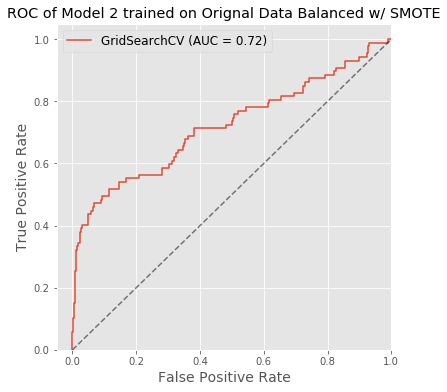

In [46]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs1, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 2 trained on Orignal Data Balanced w/ SMOTE")
ax.legend(fontsize = 12);

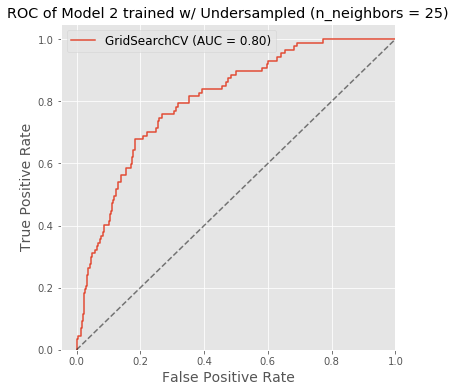

In [47]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs2, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 2 trained w/ Undersampled (n_neighbors = 25)")
ax.legend(fontsize = 12);

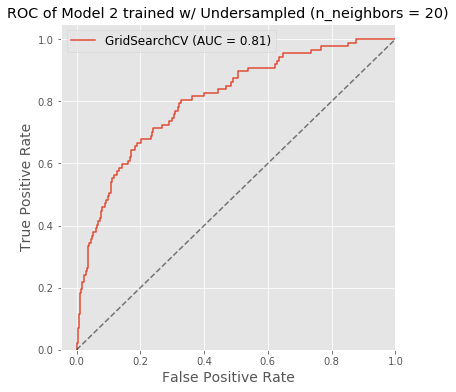

In [48]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs3, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 2 trained w/ Undersampled (n_neighbors = 20)")
ax.legend(fontsize = 12);

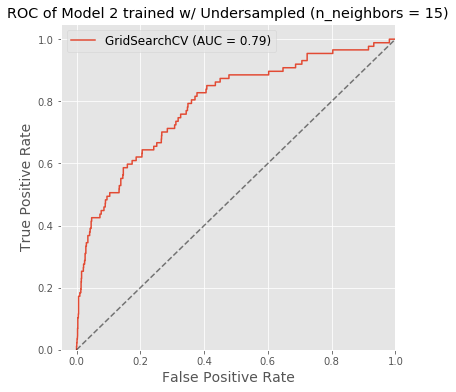

In [49]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs4, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 2 trained w/ Undersampled (n_neighbors = 15)")
ax.legend(fontsize = 12);

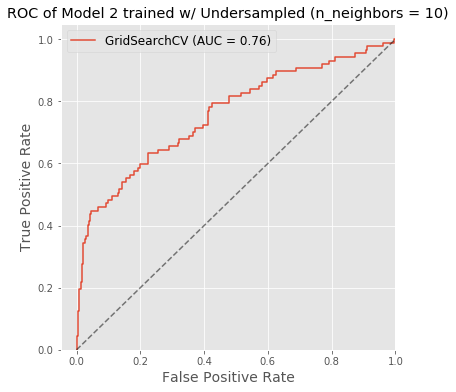

In [50]:
fig,ax = plt.subplots(figsize = (6,6))
out = plot_roc_curve(gs5, X_test, y_test, ax = ax, drop_intermediate = True) 
ax.plot([0,1],[0,1], 'k--', alpha = 0.5);
ax.set_xlim(-0.05,1)
ax.set_ylim(0,1.05)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_title("ROC of Model 2 trained w/ Undersampled (n_neighbors = 10)")
ax.legend(fontsize = 12);

# Final Evaluation of Performance

First we take a looking at the test set...

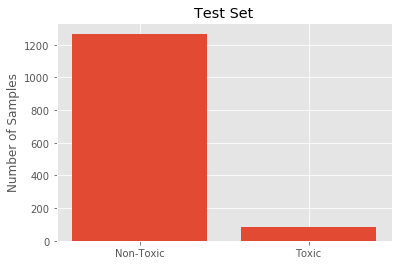

In [51]:
pos = (y_test==1).sum()

neg = (y_test==0).sum()

plt.bar(['Non-Toxic','Toxic'], [neg,pos], align='center', alpha=1)
plt.ylabel('Number of Samples')
plt.title('Test Set')

plt.show()

As you can see above, while the training set was balanced, the test set remained imbalanced.

Now we look at both models performances.

# Accuracy

In [52]:
methods = ['Original', 'Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5']

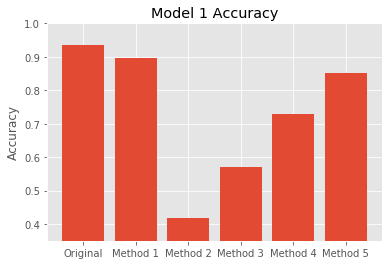

In [53]:
m1_acc = np.array([report_m1_OG['accuracy'],report_m1_1['accuracy'],report_m1_2['accuracy'],
          report_m1_3['accuracy'],report_m1_4['accuracy'],report_m1_5['accuracy']])

plt.bar(methods, m1_acc, align='center', alpha=1)
plt.ylim(0.35, 1.0)
plt.ylabel('Accuracy')
plt.title('Model 1 Accuracy')

plt.show()

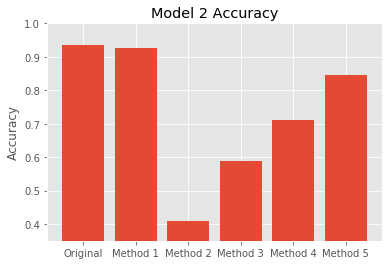

In [54]:
m2_acc = np.array([report_m2_OG['accuracy'],report_m2_1['accuracy'],report_m2_2['accuracy'],
          report_m2_3['accuracy'],report_m2_4['accuracy'],report_m2_5['accuracy']])

plt.bar(methods, m2_acc, align='center', alpha=1)
plt.ylim(0.35, 1.0)
plt.ylabel('Accuracy')
plt.title('Model 2 Accuracy')

plt.show()

In terms of accuracy, the original data performed the best. However, next when we look at precision we will see why this is very misleading...

# Precision

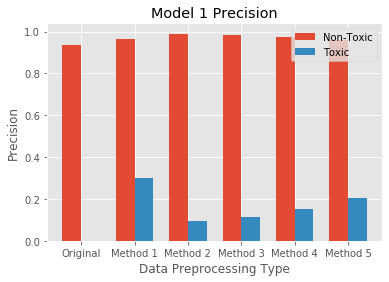

In [55]:
m1_nontox_prec = np.array([report_m1_OG['0']['precision'],report_m1_1['0']['precision'],report_m1_2['0']['precision'],
          report_m1_3['0']['precision'],report_m1_4['0']['precision'],report_m1_5['0']['precision']])

m1_tox_prec = np.array([report_m1_OG['1']['precision'],report_m1_1['1']['precision'],report_m1_2['1']['precision'],
          report_m1_3['1']['precision'],report_m1_4['1']['precision'],report_m1_5['1']['precision']])

N = 6
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, m1_nontox_prec, width, label='Non-Toxic')
plt.bar(ind + width, m1_tox_prec, width,
    label='Toxic')

plt.ylabel('Precision')
plt.xlabel('Data Preprocessing Type')
plt.title('Model 1 Precision')

plt.xticks(ind + width / 2, ('Original', 'Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5'))
plt.legend(loc='best')
plt.show()

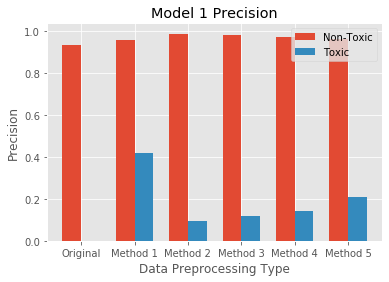

In [56]:
m2_nontox_prec = np.array([report_m2_OG['0']['precision'],report_m2_1['0']['precision'],report_m2_2['0']['precision'],
          report_m2_3['0']['precision'],report_m2_4['0']['precision'],report_m2_5['0']['precision']])

m2_tox_prec = np.array([report_m2_OG['1']['precision'],report_m2_1['1']['precision'],report_m2_2['1']['precision'],
          report_m2_3['1']['precision'],report_m2_4['1']['precision'],report_m2_5['1']['precision']])

N = 6
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, m2_nontox_prec, width, label='Non-Toxic')
plt.bar(ind + width, m2_tox_prec, width,
    label='Toxic')

plt.ylabel('Precision')
plt.xlabel('Data Preprocessing Type')
plt.title('Model 1 Precision')

plt.xticks(ind + width / 2, ('Original', 'Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5'))
plt.legend(loc='best')
plt.show()

From viewing the precisions we see that when trained with the original unbalanced data, both models classify every test sample as non-toxic. Thus it did not perform better than a random classifier. This is why the accuracy was so high for the models trained with the original data. The accuracy was aproximately <b>93%</b> because <b>93%</b> of the test molecules were non-toxic.


Method 1 of model 2 faired the best with <b>0.96</b> precision on the non-toxic class and <b>0.41</b> on the toxic class. Interpretation of this is that out of all of the test molecules this model labeled as toxic, <b>41%</b> of them were actually toxic. More so out of all the samples the model labeled as non-toxic, <b>96%</b> of them were actually non-toxic.

# Recall

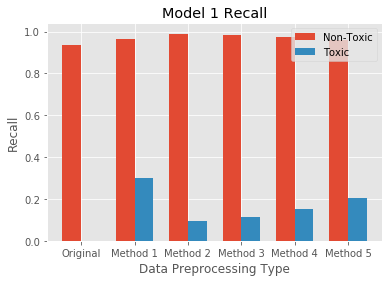

In [57]:
m1_nontox_recall = np.array([report_m1_OG['0']['recall'],report_m1_1['0']['recall'],report_m1_2['0']['recall'],
          report_m1_3['0']['recall'],report_m1_4['0']['recall'],report_m1_5['0']['recall']])

m1_tox_recall = np.array([report_m1_OG['1']['recall'],report_m1_1['1']['recall'],report_m1_2['1']['recall'],
          report_m1_3['1']['recall'],report_m1_4['1']['recall'],report_m1_5['1']['recall']])

N = 6
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, m1_nontox_prec, width, label='Non-Toxic')
plt.bar(ind + width, m1_tox_prec, width,
    label='Toxic')

plt.ylabel('Recall')
plt.xlabel('Data Preprocessing Type')
plt.title('Model 1 Recall')

plt.xticks(ind + width / 2, ('Original', 'Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5'))
plt.legend(loc='best')
plt.show()

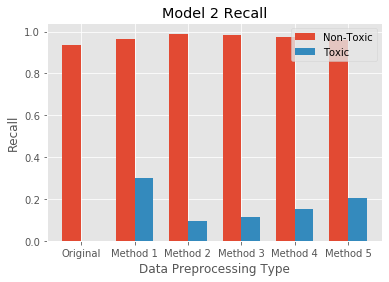

In [58]:
m2_nontox_recall = np.array([report_m2_OG['0']['recall'],report_m2_1['0']['recall'],report_m2_2['0']['recall'],
          report_m2_3['0']['recall'],report_m2_4['0']['recall'],report_m2_5['0']['recall']])

m2_tox_recall = np.array([report_m2_OG['1']['recall'],report_m2_1['1']['recall'],report_m2_2['1']['recall'],
          report_m2_3['1']['recall'],report_m2_4['1']['recall'],report_m2_5['1']['recall']])

N = 6
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, m1_nontox_prec, width, label='Non-Toxic')
plt.bar(ind + width, m1_tox_prec, width,
    label='Toxic')

plt.ylabel('Recall')
plt.xlabel('Data Preprocessing Type')
plt.title('Model 2 Recall')

plt.xticks(ind + width / 2, ('Original', 'Method 1', 'Method 2', 'Method 3', 'Method 4', 'Method 5'))
plt.legend(loc='best')
plt.show()

From viewing the recalls we see that both models performed the same in terms of highest recall. Both models trained with method 1 data had a recall of <b>0.4</b> for the toxic class and <b>0.96</b> for the non-toxic class. 

This can be interpreted as out of all the truly toxic molecules in the test set, both models correctly labeled <b>40%</b> of them. Moreover out of all of the truly non-toxic molecules in the test set, both models correctly labeled <b>96%</b> of them.

It is worth noting that the recall for the toxic class increased to <b>93%</b> when method 2 data was used to train the models, however the non-toxic class suffered with a recall of <b>38%</b> with model 1 and <b>37%</b> with model 2.

# AUROC

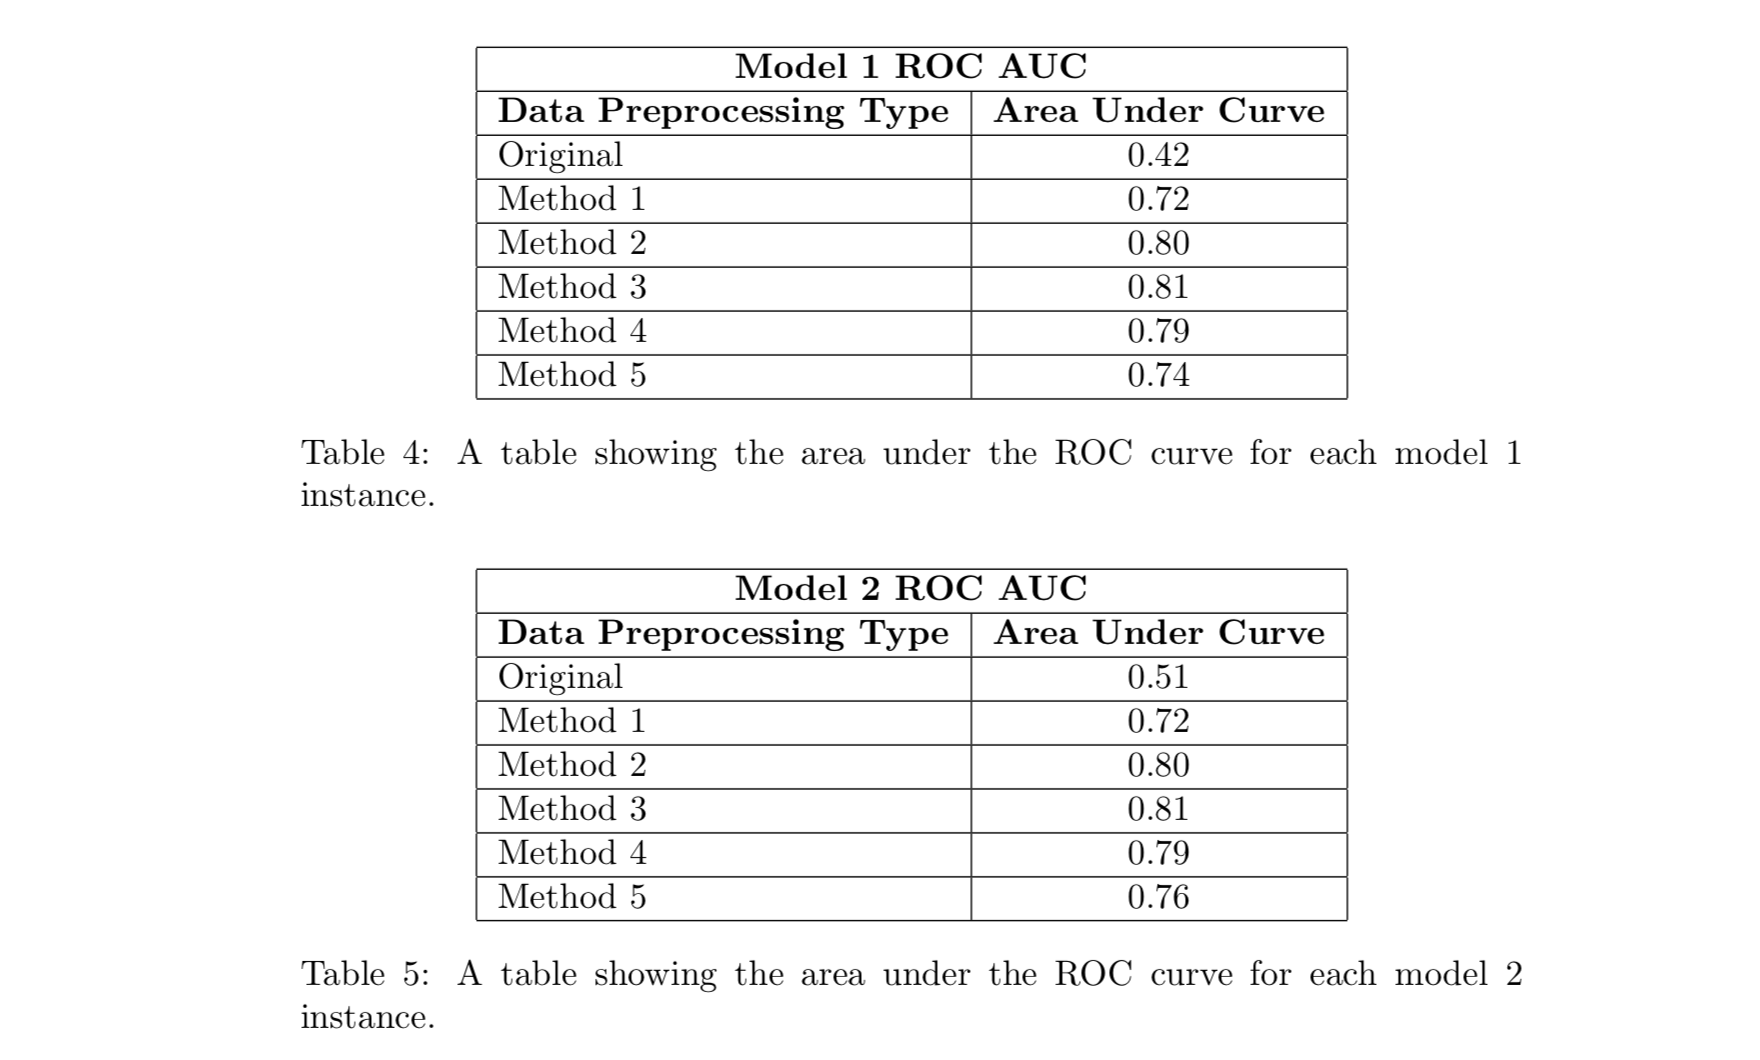

In [59]:
from IPython.display import Image
Image(filename='data/AUROC tables.png')

Above are tables from the report on this research written in Latex showing the area under the ROC curve. The following is an excerpt from that report disscussing the AUROC.

"When examining the performance of a classification model, one of the most important metrics to refer to is the ROC curve and the area under it. The ROC is a probability curve and the area under it is a measure of separability, or how capable the model is of distinguishing between classes. When examining each instance of model 1 and model 2’s ROC curve, there was not much of a difference. The area under the ROC curves were the same for both models besides method 5, which had an AUC of <b>0.74</b> for model 1 and <b>0.76</b> for model 2. The method that had the largest AUC was method 3, with an AUC of <b>0.81</b>. Therefore data preprocessing method 3 created optimal training data for the models, thus the models trained with method 3 data were the best at distinguishing between toxic and non-toxic molecules."